[View in Colaboratory](https://colab.research.google.com/github/r9y9/Colaboratory/blob/master/DeepVoice3_multi_speaker_TTS_en_demo.ipynb)

# DeepVoice3: Multi-speaker text-to-speech demo

In this notebook, you can try DeepVoice3-based multi-speaker text-to-speech (en) using a model trained on [VCTK dataset](http://homepages.inf.ed.ac.uk/jyamagis/page3/page58/page58.html). The notebook is supposed to be executed on [Google colab](https://colab.research.google.com) so you don't have to setup your machines locally.

**Estimated time to complete**: 5 miniutes.

- Code: https://github.com/r9y9/deepvoice3_pytorch
- Audio samples: https://r9y9.github.io/deepvoice3_pytorch/

## Setup

### Install dependencies

In [9]:
import os
from os.path import exists, join, expanduser

# Clone
name = "deepvoice3_pytorch"
if not exists(name):
  ! git clone https://github.com/r9y9/$name

In [10]:
# Change working directory to the project dir 
os.chdir(join(expanduser("~"), name))

# Install pytorch v0.3.1
!pip install -q torch==0.3.1

# Install dependencices
!pip install -q -e '.[train]'

In [11]:
%pylab inline
! pip install -q librosa nltk

import torch
import numpy as np
import librosa
import librosa.display
import IPython
from IPython.display import Audio
# need this for English text processing frontend
import nltk
! python -m nltk.downloader cmudict

Populating the interactive namespace from numpy and matplotlib
/usr/lib/python3.6/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package cmudict to /content/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


### Download a pre-trained model

In [12]:
checkpoint_path = "20171222_deepvoice3_vctk108_checkpoint_step000300000.pth"

In [13]:
if not exists(checkpoint_path):
  !curl -O -L "https://www.dropbox.com/s/uzmtzgcedyu531k/20171222_deepvoice3_vctk108_checkpoint_step000300000.pth"

### git checkout to the working commit

In [14]:
# Copy preset file (json) from master
# The preset file describes hyper parameters
! git checkout master --quiet
preset = "./presets/deepvoice3_vctk.json"
! cp -v $preset .
preset = "./deepvoice3_vctk.json"

# And then git checkout to the working commit
# This is due to the model was trained a few months ago and it's not compatible
# with the current master. 
! git checkout 0421749 --quiet
! pip install -q -e .

'./presets/deepvoice3_vctk.json' -> './deepvoice3_vctk.json'


## Synthesis

### Setup hyper parameters

In [15]:
import hparams
import json

# Newly added params. Need to inject dummy values
for dummy, v in [("fmin", 0), ("fmax", 0), ("rescaling", False),
                 ("rescaling_max", 0.999), 
                 ("allow_clipping_in_normalization", False)]:
  if hparams.hparams.get(dummy) is None:
    hparams.hparams.add_hparam(dummy, v)
    
# Load parameters from preset
with open(preset) as f:
  hparams.hparams.parse_json(f.read())

# Tell we are using multi-speaker DeepVoice3
hparams.hparams.builder = "deepvoice3_multispeaker"
  
# Inject frontend text processor
import synthesis
import train
from deepvoice3_pytorch import frontend
synthesis._frontend = getattr(frontend, "en")
train._frontend =  getattr(frontend, "en")

# alises
fs = hparams.hparams.sample_rate
hop_length = hparams.hparams.hop_size

### Define utility functions

In [16]:
def tts(model, text, p=0, speaker_id=0, fast=True, figures=True):
  from synthesis import tts as _tts
  waveform, alignment, spectrogram, mel = _tts(model, text, p, speaker_id, fast)
  if figures:
      visualize(alignment, spectrogram)
  IPython.display.display(Audio(waveform, rate=fs))
  
def visualize(alignment, spectrogram):
  label_fontsize = 16
  figure(figsize=(16,16))

  subplot(2,1,1)
  imshow(alignment.T, aspect="auto", origin="lower", interpolation=None)
  xlabel("Decoder timestamp", fontsize=label_fontsize)
  ylabel("Encoder timestamp", fontsize=label_fontsize)
  colorbar()

  subplot(2,1,2)
  librosa.display.specshow(spectrogram.T, sr=fs, 
                           hop_length=hop_length, x_axis="time", y_axis="linear")
  xlabel("Time", fontsize=label_fontsize)
  ylabel("Hz", fontsize=label_fontsize)
  tight_layout()
  colorbar()

### Load the model checkpoint

In [17]:
from train import build_model
from train import restore_parts, load_checkpoint

model = build_model()
model = load_checkpoint(checkpoint_path, model, None, True)

Load checkpoint from: 20171222_deepvoice3_vctk108_checkpoint_step000300000.pth


### Generate speech

In [18]:
# Try your favorite senteneces:)
text = "Some have accepted this as a miracle without any physical explanation"
N = 15
print("Synthesizing \"{}\" with {} different speakers".format(text, N))
for speaker_id in range(N):
  print(speaker_id)
  tts(model, text, speaker_id=speaker_id, figures=False)

Synthesizing "Some have accepted this as a miracle without any physical explanation" with 15 different speakers
0


1


2


3


4


5


6


7


8


9


10


11


12


13


14


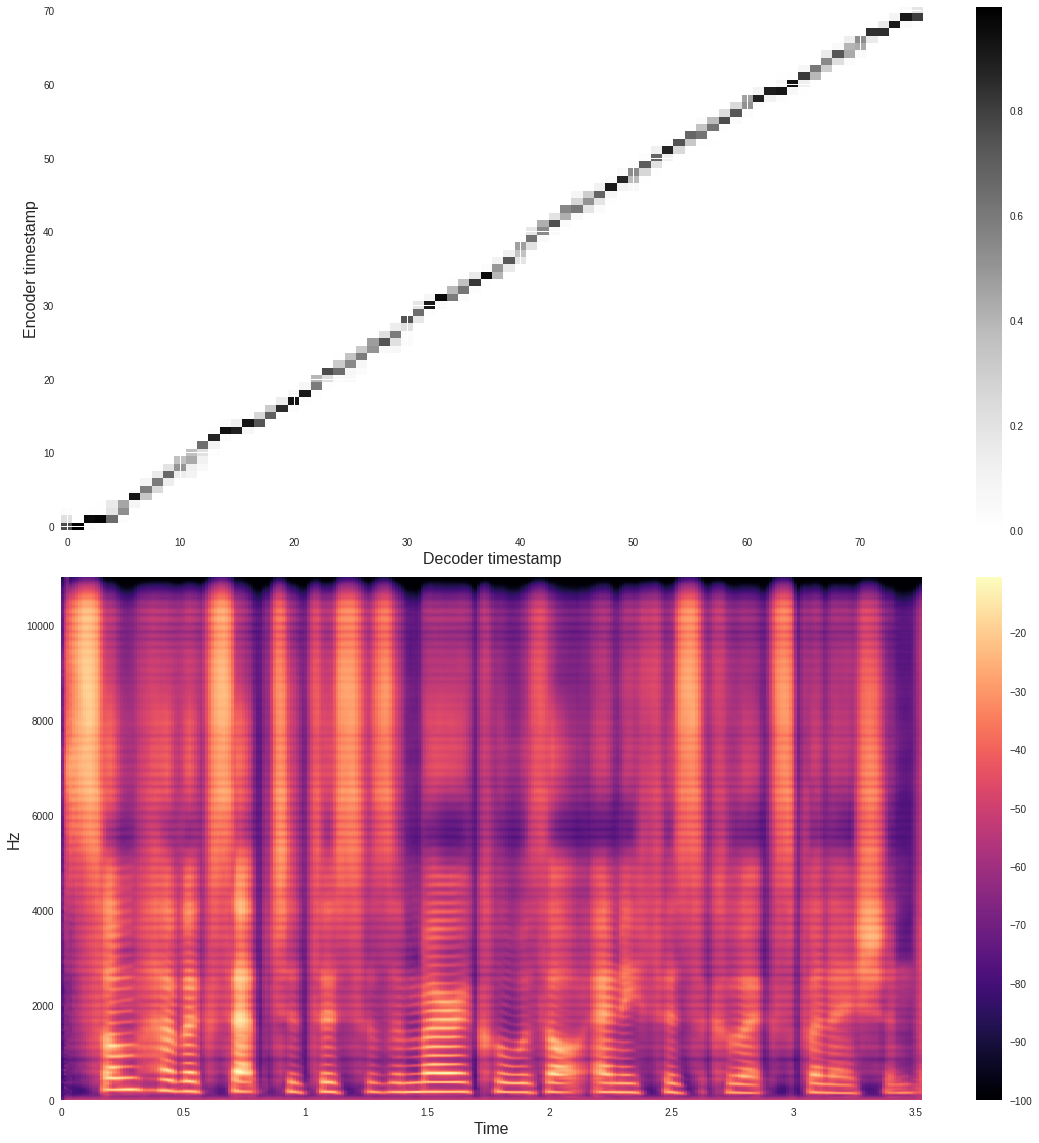

In [19]:
# With attention plot
tts(model, text, speaker_id=0, figures=True)

For details, please visit https://github.com/r9y9/deepvoice3_pytorch